In [1]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize.utils import mkvc
from SimPEG.utils import plot2Ddata, model_builder, surface2ind_topo
from SimPEG import maps, utils
from SimPEG.potential_fields import magnetics

write_output = False

# sphinx_gallery_thumbnail_number = 2

In [2]:
[x_topo, y_topo] = np.meshgrid(np.linspace(-200, 200, 41), np.linspace(-200, 200, 41))
z_topo = 0 * np.exp(-((x_topo-5) ** 2 + y_topo ** 2) / 80 ** 2)
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
xyz_topo = np.c_[x_topo, y_topo, z_topo]

In [3]:
xyz_topo.shape

(1681, 3)

In [4]:
print(xyz_topo)

[[-200. -200.    0.]
 [-200. -190.    0.]
 [-200. -180.    0.]
 ...
 [ 200.  180.    0.]
 [ 200.  190.    0.]
 [ 200.  200.    0.]]


In [5]:
# Define the observation locations as an (N, 3) numpy array or load them.
x = np.linspace(-50.0, 50.0, 28)
y = np.linspace(-50.0, 50.0, 28)
x, y = np.meshgrid(x, y)
x, y = mkvc(x.T), mkvc(y.T)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) + 10  # Flight height 10 m above surface.
receiver_locations = np.c_[x, y, z]

# Define the component(s) of the field we want to simulate as a list of strings.
# Here we simulation total magnetic intensity data.
components = ["tmi"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = magnetics.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

# Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
inclination = 90
declination = 0
strength = 50000
inducing_field = (strength, inclination, declination)

source_field = magnetics.sources.SourceField(
    receiver_list=receiver_list, parameters=inducing_field
)

# Define the survey
survey = magnetics.survey.Survey(source_field)

In [6]:
dh = 10.0

hx = [(dh, 10)]
hy = [(dh, 10)]
hz = [(dh, 3)]
mesh = TensorMesh([hx, hy, hz], "CCN")

In [7]:
print(type(mesh))
mesh.nCx

<class 'discretize.tensor_mesh.TensorMesh'>


10

In [28]:
# Define susceptibility values for each unit in SI
background_susceptibility = 0.0001
pipe_susceptibility = 1

# Find cells that are active in the forward modeling (cells below surface)
ind_active = surface2ind_topo(mesh, xyz_topo)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model is a vlue for each active cell
print("Background sus: " + str(background_susceptibility))

Background sus: 0.0001


In [29]:
# Define model. Models in SimPEG are vector arrays
model = background_susceptibility * np.ones(ind_active.sum())

#indices go through x, y, then z, from bottom up
xp = 2
yp = np.arange(mesh.nCy) #goes along y direction, covers each y
zp = 1

rp = xp + mesh.nCx * yp + mesh.nCx * mesh.nCy * zp
print(rc)


[102 112 122 132 142 152 162 172 182 192]


In [30]:
pipe_indices = rp
model[pipe_indices] = pipe_susceptibility

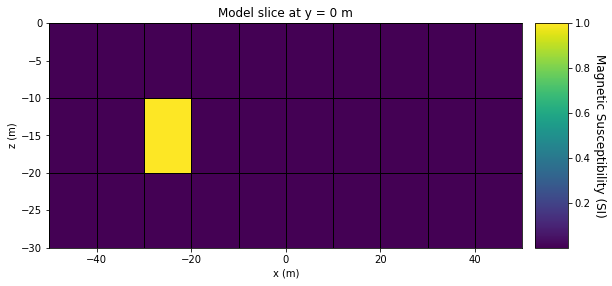

In [31]:
# Plot Model
fig = plt.figure(figsize=(9, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plotSlice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=3,
    grid=True,
    clim=(np.min(model), np.max(model)),
)
ax1.set_title("Model slice at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
cbar.set_label("Magnetic Susceptibility (SI)", rotation=270, labelpad=15, size=12)

plt.show()

In [32]:
# Define the forward simulation. By setting the 'store_sensitivities' keyword
# argument to "forward_only", we simulate the data without storing the sensitivities
simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    model_type="scalar",
    chiMap=model_map,
    actInd=ind_active,
    store_sensitivities="forward_only",
)

# Compute predicted data for a susceptibility model
dpred = simulation.dpred(model)



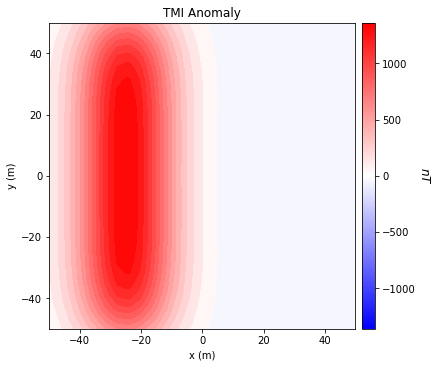

In [33]:
# Plot
fig = plt.figure(figsize=(6, 5))
v_max = np.max(np.abs(dpred))

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred,
    ax=ax1,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
ax1.set_title("TMI Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.87, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dpred)), vmax=np.max(np.abs(dpred)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$nT$", rotation=270, labelpad=15, size=12)

plt.show()


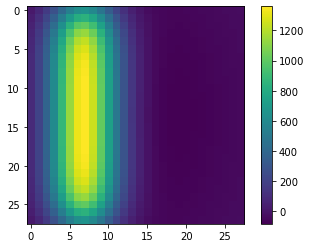

In [39]:
dF2D = dpred.reshape([28,28])
plt.imshow(dF2D)
plt.colorbar()

# Random noise